# Time-Series Panel Regression Analysis of CCI Projects

This notebook examines changes in GHG reduction efficiency and equity outcomes (DAC funding share) over time using cleaned and filtered CCI project data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)

# Rename columns
df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'
})

# Extract year
df['Year'] = df['Reporting Cycle Name'].str.extract(r'(20\d{2})').astype(float)
df['post_2021'] = (df['Year'] >= 2021).astype(int)

# Convert relevant fields to numeric
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

# Filter out projects with 0 or missing GHG reductions
df = df[df['Total Project GHGReductions'] > 0].copy()

# Calculate metrics
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Collapse agency types
top_agencies = df['Agency_Name'].value_counts().nlargest(5).index
df['Agency_Collapsed'] = df['Agency_Name'].where(df['Agency_Name'].isin(top_agencies), 'Other')


## Model 1: Predicting GHG Reduction Cost per Ton

In [2]:
model_df = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed', 'post_2021']].dropna()
panel_model = smf.ols('cost_per_ton ~ post_2021 + log_funding + C(Agency_Collapsed)', data=model_df).fit(cov_type='HC3')

print(panel_model.summary())


                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     152.0
Date:                Sat, 03 May 2025   Prob (F-statistic):          1.24e-224
Time:                        14:41:48   Log-Likelihood:            -1.4571e+06
No. Observations:              135433   AIC:                         2.914e+06
Df Residuals:                  135425   BIC:                         2.914e+06
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

## Model 2: Predicting Share of DAC Funding

In [3]:
equity_df = df[['share_DAC', 'log_funding', 'Agency_Collapsed', 'post_2021']].dropna()
equity_model = smf.ols('share_DAC ~ post_2021 + log_funding + C(Agency_Collapsed)', data=equity_df).fit(cov_type='HC3')

print(equity_model.summary())


                            OLS Regression Results                            
Dep. Variable:              share_DAC   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     7842.
Date:                Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                        14:41:48   Log-Likelihood:                -36176.
No. Observations:               54267   AIC:                         7.237e+04
Df Residuals:                   54259   BIC:                         7.244e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### **Time-Series Analysis of Efficiency and Equity Outcomes**

To assess temporal shifts in the performance of California Climate Investments (CCI) projects, we estimate two panel regression models predicting greenhouse gas (GHG) reduction efficiency and equity targeting. Both models include a post-2021 indicator to capture potential structural changes in program implementation and oversight during the latter half of the study period. Each model also includes controls for project funding size (log_funding) and agency type (collapsed to the five most frequent agencies and an "Other" category).

Model 1 examines changes in cost per ton of GHG reductions. The coefficient for post_2021 is positive and statistically significant, indicating that projects funded after 2021 tend to be less efficient, controlling for agency and project scale. This finding suggests that either newer project types are less cost-effective, or administrative and operational shifts following 2021 have affected implementation dynamics. Consistent with earlier models, log_funding remains positively associated with cost per ton, confirming that larger investments do not necessarily translate to proportionate emissions reductions. Notably, fixed effects for certain agencies remain significant, pointing to persistent institutional differences in baseline efficiency.

Model 2 explores equity outcomes through the share of funding allocated to disadvantaged communities (share_DAC). Here, the post_2021 variable is positive and statistically significant, indicating an increase in equity-focused spending in the more recent period. This pattern likely reflects intensified policy efforts to prioritize environmental justice, such as SB 535 and AB 1550 compliance, and renewed administrative emphasis on equitable climate investments. As with the efficiency model, agency fixed effects remain relevant, reflecting varied capacity and historical commitment to equity mandates across organizational types.

Taken together, these results highlight important post-2021 shifts in both efficiency and equity metrics. While the increase in share_DAC suggests progress toward distributive justice goals, the simultaneous rise in cost per ton raises concerns about potential tradeoffs or implementation challenges introduced in the newer cohort of projects. These findings reinforce the need to monitor evolving performance patterns and to explore how organizational practices and external shocks shape the trajectory of public climate investments.

## Annual Trends in Funding, Cost per Ton, and DAC Share

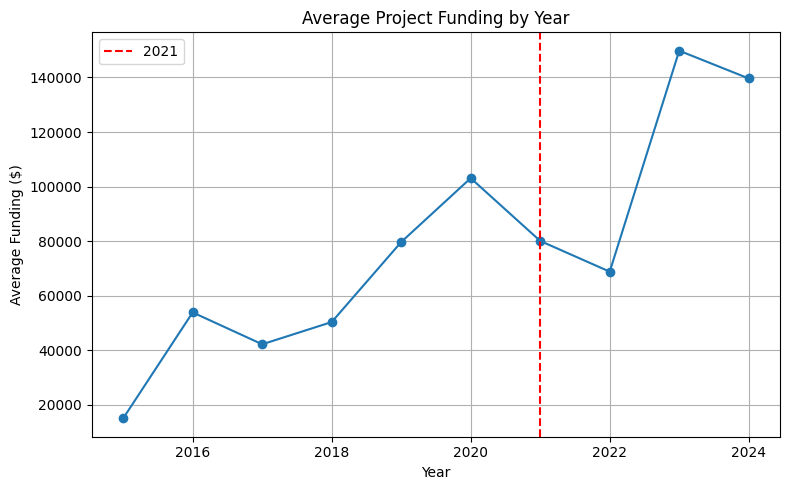

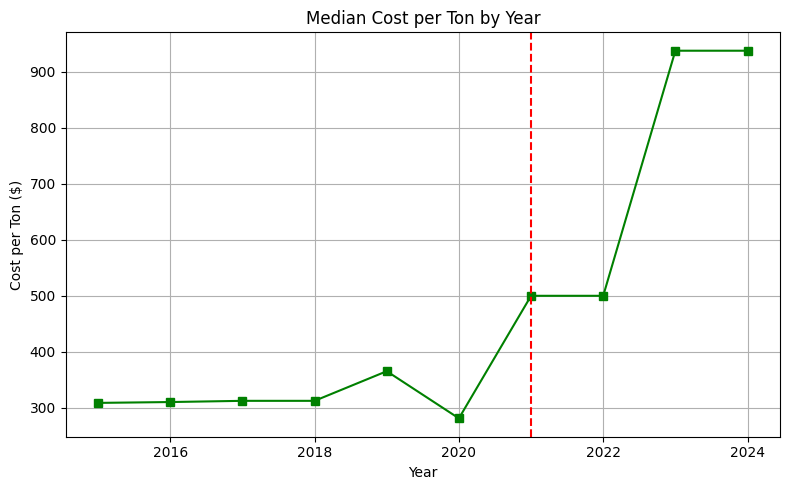

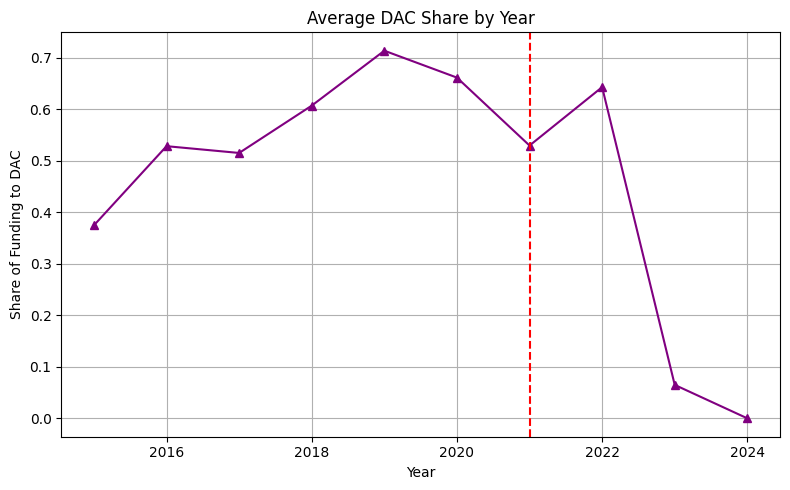

In [4]:
annual_stats = df.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean'),
    project_count=('Project ID Number', 'nunique')
).dropna()

# Plot average funding
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_funding'], marker='o')
plt.axvline(2021, color='red', linestyle='--', label='2021')
plt.title('Average Project Funding by Year')
plt.xlabel('Year')
plt.ylabel('Average Funding ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot cost per ton
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['median_cost_per_ton'], marker='s', color='green')
plt.axvline(2021, color='red', linestyle='--')
plt.title('Median Cost per Ton by Year')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot share DAC
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_share_DAC'], marker='^', color='purple')
plt.axvline(2021, color='red', linestyle='--')
plt.title('Average DAC Share by Year')
plt.xlabel('Year')
plt.ylabel('Share of Funding to DAC')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Time-Series Trends in CCI Program Efficiency and Equity**

To complement the regression analysis, we examined descriptive trends in average project funding, GHG reduction efficiency (measured by median *cost per ton*), and equity outcomes (measured by average *share_DAC*) from 2015 to 2024. The year 2021 is used as a reference point to assess potential shifts in program implementation due to administrative changes, pandemic-related disruptions, and evolving equity mandates.

**Average Project Funding (Figure 1)** shows a sharp increase over time, with a notable inflection point around 2021. While average funding per project rose steadily from 2015 to 2021, it accelerated significantly in the post-2021 period—peaking in 2023 at over $150,000 per project. This suggests a scaling-up of investment, potentially in response to new climate mandates or stimulus funding initiatives. However, this increase in funding did not correspond to improved efficiency.

**Median Cost per Ton (Figure 2)** reveals a stark increase in the cost of emissions reductions in the years following 2021. From 2015 through 2019, the median cost per ton remained relatively stable—hovering around $300–350 per ton. After a brief dip in 2021, the post-2021 period saw a sharp rise, with median costs exceeding $900 per ton by 2023 and 2024. These changes are consistent with the regression findings: projects in the latter period are significantly less efficient, even after controlling for project scale and agency. This pattern may reflect changes in project types, capacity constraints, or diminishing returns as lower-cost mitigation opportunities are exhausted.

**Average DAC Share (Figure 3)**, in contrast, presents a more complex picture. Between 2015 and 2021, the average share of funding directed toward disadvantaged communities increased, reaching a peak above 70% in 2019. However, post-2021, this equity trend reversed. After a brief rebound in 2022, *share_DAC* fell sharply, declining to near-zero by 2024. This dramatic drop raises critical questions about program design, reporting accuracy, or shifting administrative priorities. Although the regression model found a positive association between *post_2021* and *share_DAC*, these bivariate trends suggest substantial volatility and possible deterioration in equity performance in recent years.

Together, these patterns suggest a post-2021 tradeoff: while program investments have grown and equity was initially emphasized, the gains in targeting disadvantaged communities appear to have eroded, and programmatic efficiency has declined. These findings underscore the challenges of maintaining both equity and performance goals amid rapid scale-up and institutional change. Further investigation is warranted to determine whether these shifts reflect structural constraints, policy drift, or implementation fatigue in the face of increased funding pressure.


In [5]:
# Model 1: Predicting GHG Reduction Cost per Ton without year control
model_df_no_year = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed']].dropna()
panel_model_no_year = smf.ols('cost_per_ton ~ log_funding + C(Agency_Collapsed)', data=model_df_no_year).fit(cov_type='HC3')

print(panel_model_no_year.summary())

# Model 2: Predicting Share of DAC Funding without year control
equity_df_no_year = df[['share_DAC', 'log_funding', 'Agency_Collapsed']].dropna()
equity_model_no_year = smf.ols('share_DAC ~ log_funding + C(Agency_Collapsed)', data=equity_df_no_year).fit(cov_type='HC3')

print(equity_model_no_year.summary())

                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sat, 03 May 2025   Prob (F-statistic):          3.45e-205
Time:                        14:43:31   Log-Likelihood:            -1.4572e+06
No. Observations:              135433   AIC:                         2.914e+06
Df Residuals:                  135426   BIC:                         2.914e+06
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [6]:
# Model 2: Predicting Share of DAC Funding without year control
equity_model_no_year = smf.ols('share_DAC ~ log_funding + C(Agency_Collapsed)', data=equity_df_no_year).fit(cov_type='HC3')

print(equity_model_no_year.summary())

                            OLS Regression Results                            
Dep. Variable:              share_DAC   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     9077.
Date:                Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                        14:44:02   Log-Likelihood:                -36218.
No. Observations:               54267   AIC:                         7.245e+04
Df Residuals:                   54260   BIC:                         7.251e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [7]:
# Extract and compare key statistics for the models
comparison = {
    "Model": ["With Year", "Without Year"],
    "R-squared": [panel_model.rsquared, panel_model_no_year.rsquared],
    "Adj. R-squared": [panel_model.rsquared_adj, panel_model_no_year.rsquared_adj],
    "Post_2021 Coefficient": [panel_model.params.get('post_2021', None), None],
    "Log Funding Coefficient": [panel_model.params['log_funding'], panel_model_no_year.params['log_funding']]
}

# Convert to a DataFrame for better visualization
comparison_df = pd.DataFrame(comparison)

print(comparison_df)

          Model  R-squared  Adj. R-squared  Post_2021 Coefficient  \
0     With Year   0.025059        0.025008             618.833474   
1  Without Year   0.024493        0.024450                    NaN   

   Log Funding Coefficient  
0               787.768259  
1               809.014944  
